In [1]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")


In [2]:
!kaggle datasets download -d andrewmvd/car-plate-detection


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
License(s): CC0-1.0
 98% 200M/203M [00:10<00:00, 23.4MB/s]
100% 203M/203M [00:10<00:00, 21.0MB/s]


In [3]:
!unzip car-plate-detection.zip -d /content/car-plate-detection


Archive:  car-plate-detection.zip
  inflating: /content/car-plate-detection/annotations/Cars0.xml  
  inflating: /content/car-plate-detection/annotations/Cars1.xml  
  inflating: /content/car-plate-detection/annotations/Cars10.xml  
  inflating: /content/car-plate-detection/annotations/Cars100.xml  
  inflating: /content/car-plate-detection/annotations/Cars101.xml  
  inflating: /content/car-plate-detection/annotations/Cars102.xml  
  inflating: /content/car-plate-detection/annotations/Cars103.xml  
  inflating: /content/car-plate-detection/annotations/Cars104.xml  
  inflating: /content/car-plate-detection/annotations/Cars105.xml  
  inflating: /content/car-plate-detection/annotations/Cars106.xml  
  inflating: /content/car-plate-detection/annotations/Cars107.xml  
  inflating: /content/car-plate-detection/annotations/Cars108.xml  
  inflating: /content/car-plate-detection/annotations/Cars109.xml  
  inflating: /content/car-plate-detection/annotations/Cars11.xml  
  inflating: /conten

In [5]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split

In [4]:
dataset_path = 'car-plate-detection'

import re

def the_number_in_the_string(filename):

    match = re.search(r'(\d+)', filename)

    if match:
        return int(match.group(0))
    else:
        return 0

In [9]:
labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)

xml_files = glob(f'{dataset_path}/annotations/*.xml')

for filename in sorted(xml_files, key=the_number_in_the_string):
    info = xet.parse(filename)
    root = info.getroot()

    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

alldata = pd.DataFrame(labels_dict)

alldata.head(3)

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,car-plate-detection/images/Cars0.png,226,419,125,173,500,268
1,car-plate-detection/images/Cars1.png,134,262,128,160,400,248
2,car-plate-detection/images/Cars2.png,229,270,176,193,400,400


In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(alldata, test_size = 0.1, random_state=42)

train, val = train_test_split(train, train_size = 8/9, random_state=42)

print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')



      len(train) = 345
      len(val) = 44
      len(test) = 44



In [11]:
def make_split_folder_in_yolo_format(split_name, split_df):
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    os.makedirs(labels_path)
    os.makedirs(images_path)


    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))


        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")

        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")

In [12]:
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
Created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels'
Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


In [17]:
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''


with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

In [18]:
from ultralytics import YOLO
model = YOLO('yolov9s.pt')

In [22]:
model.train(
    data='datasets.yaml',
    epochs=25,
    batch=16,
    device='cuda',
    imgsz=320,
    cache='disk'
)

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9s.pt, data=datasets.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=cuda, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

train: Scanning /content/datasets/cars_license_plate_new/train/labels.cache... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<?, ?it/s]
train: Caching images (0.1GB Disk): 100%|██████████| 345/345 [00:05<00:00, 66.91it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/cars_license_plate_new/val/labels.cache... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<?, ?it/s]
val: Caching images (0.0GB Disk): 100%|██████████| 44/44 [00:00<00:00, 85.07it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      1.73G      1.471     0.8852      1.279         19        320: 100%|██████████| 22/22 [00:06<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.26it/s]

                   all         44         44       0.65      0.773      0.739      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25       1.5G      1.349     0.8296      1.207         17        320: 100%|██████████| 22/22 [00:07<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]

                   all         44         44        0.9      0.818      0.895      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      1.55G      1.315     0.8193      1.185         23        320: 100%|██████████| 22/22 [00:05<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]

                   all         44         44      0.887      0.432      0.541      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25       1.5G      1.352     0.8676      1.226         13        320: 100%|██████████| 22/22 [00:07<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.75it/s]

                   all         44         44      0.836      0.591      0.673      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25       1.5G      1.364     0.8698      1.248         18        320: 100%|██████████| 22/22 [00:05<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         44         44      0.633      0.628      0.624      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      1.55G      1.418     0.9578      1.258         21        320: 100%|██████████| 22/22 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]

                   all         44         44     0.0242     0.0227    0.00263    0.00236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25       1.5G      1.369      0.849      1.259         20        320: 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

                   all         44         44      0.853      0.527      0.608      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      1.55G      1.344     0.7888      1.215         20        320: 100%|██████████| 22/22 [00:06<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.79it/s]

                   all         44         44      0.899      0.432      0.471      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25       1.5G      1.301     0.8045      1.185         14        320: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

                   all         44         44      0.936      0.523      0.628      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      1.55G      1.305      0.763      1.204         16        320: 100%|██████████| 22/22 [00:06<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.07it/s]

                   all         44         44      0.873       0.78       0.84      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25       1.5G      1.351     0.7738      1.195         19        320: 100%|██████████| 22/22 [00:05<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

                   all         44         44      0.888      0.773      0.855      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      1.55G      1.278      0.745      1.151         19        320: 100%|██████████| 22/22 [00:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

                   all         44         44      0.916       0.74      0.851      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       1.5G      1.279     0.7291      1.196         13        320: 100%|██████████| 22/22 [00:05<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

                   all         44         44      0.974      0.839      0.915      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      1.55G      1.265     0.7407      1.211         15        320: 100%|██████████| 22/22 [00:06<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]

                   all         44         44       0.89      0.841       0.89       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25       1.5G      1.207     0.6848      1.171         19        320: 100%|██████████| 22/22 [00:05<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

                   all         44         44      0.886      0.841      0.894        0.5


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      1.55G      1.234     0.7036      1.182          9        320: 100%|██████████| 22/22 [00:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.31it/s]

                   all         44         44      0.839      0.864      0.892      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25       1.5G      1.254     0.7058      1.193          9        320: 100%|██████████| 22/22 [00:06<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

                   all         44         44      0.874      0.841      0.899      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      1.55G       1.21     0.6596      1.183          9        320: 100%|██████████| 22/22 [00:05<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.67it/s]

                   all         44         44      0.825      0.864      0.905      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      1.49G      1.196     0.6377      1.163          9        320: 100%|██████████| 22/22 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         44         44      0.885      0.841      0.905        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      1.55G      1.143     0.5969      1.134          9        320: 100%|██████████| 22/22 [00:06<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.04it/s]

                   all         44         44       0.86      0.864      0.868      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      1.49G      1.136     0.6382      1.134          9        320: 100%|██████████| 22/22 [00:05<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]

                   all         44         44      0.861      0.886      0.913      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      1.55G      1.143     0.6018      1.119          9        320: 100%|██████████| 22/22 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         44         44      0.885      0.873      0.917      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      1.49G      1.073     0.5718      1.086          9        320: 100%|██████████| 22/22 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         44         44      0.928      0.875      0.926      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      1.55G      1.079     0.5739      1.111          9        320: 100%|██████████| 22/22 [00:06<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.34it/s]

                   all         44         44      0.905       0.87      0.932      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      1.49G      1.092     0.5537      1.092          9        320: 100%|██████████| 22/22 [00:05<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

                   all         44         44      0.906      0.886      0.932       0.56



25 epochs completed in 0.060 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 15.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 15.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9s summary (fused): 486 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]


                   all         44         44      0.905       0.87      0.932      0.565
Speed: 0.1ms preprocess, 3.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x793d202107c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [159]:
results = model.val()

print(f"Results: {results}")

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/datasets/cars_license_plate_new/val/labels.cache... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<?, ?it/s]
val: Caching images (0.0GB Disk): 100%|██████████| 44/44 [00:00<00:00, 21847.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


                   all         44         44      0.905       0.87      0.932      0.559
Speed: 0.2ms preprocess, 9.5ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/train42
Results: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x793d21a9d000>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032


0: 192x320 1 license_plate, 94.1ms
Speed: 2.0ms preprocess, 94.1ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 320)
Detected 1 license plates.
Bounding box: x=143, y=127, w=114, h=31
Cropped license plate region after preprocessing: (30, 114, 3)


Detected text: DZI7 YXR


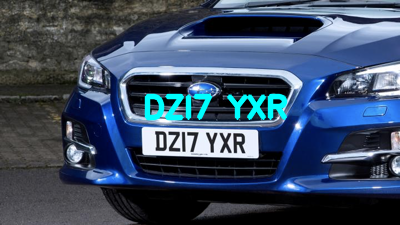

In [157]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import easyocr

def process_and_display_image(image_path, model):
    image = cv2.imread(image_path)
    if image is None or image.size == 0:
        raise ValueError(f"Failed to load image from {image_path}")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    results = model(image_rgb)

    boxes = results[0].boxes.xywh.cpu().numpy()
    confidences = results[0].boxes.conf.cpu().numpy()

    print(f"Detected {len(boxes)} license plates.")

    indices = non_maximum_suppression(boxes.tolist(), confidences.tolist())

    ocr_reader = easyocr.Reader(['en'])

    for i in indices.flatten():
        box = boxes[i]
        x_center, y_center, w, h = map(int, box)

        x1 = x_center - (w // 2)
        y1 = y_center - (h // 2)
        x2 = x_center + (w // 2)
        y2 = y_center + (h // 2)

        print(f"Bounding box: x={x1}, y={y1}, w={w}, h={h}")

        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(image.shape[1], x2)
        y2 = min(image.shape[0], y2)

        plate_region = image[y1:y2, x1:x2]

        gray_plate = cv2.cvtColor(plate_region, cv2.COLOR_BGR2GRAY)
        _, thresh_plate = cv2.threshold(gray_plate, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        print(f"Cropped license plate region after preprocessing: {plate_region.shape}")
        cv2_imshow(thresh_plate)
        cv2.waitKey(0)

        ocr_text = ocr_reader.readtext(thresh_plate)

        if len(ocr_text) == 0:
            print("No text detected.")
        else:
            for ocr_item in ocr_text:
                text = ocr_item[1]
                print(f"Detected text: {text}")

                cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 3, lineType=cv2.LINE_AA)

    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

image_path = 'datasets/cars_license_plate_new/test/images/Cars428.png'
process_and_display_image(image_path, model)


In [45]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 26.5 MB/s eta 0:00:00
